In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import geopandas as gpd
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import sys
from tqdm import tqdm

from shapely.geometry import LineString

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/chriscarey/miniconda3/envs/mlc/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.5 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [3]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
LIB_DIR = '../../lib'
LOG_DIR = '../../../log'

In [4]:
# Custom imports
sys.path.append(LIB_DIR)
from gtfs_sequence import Sequence

In [5]:
def peek(df):
    print(len(df))
    display(df.iloc[:3])

# 1. Extract MultiLineString Routes

All of the route geometries in `bus_routes_nyc_may2020.shp` should be LineStrings - each bus route should be represented by a single list of consecutive coordinates representing a single contiguous line. However, some geometries are MultiLineStrings which include LineStrings which are out of order or incorrectly branch off of the legitimate bus route. The goal of this notebook is to ingest the MultiLineStrings, extract the correct sequence of coordinates representing the bus route, and export them as a single LineString.

In [6]:
route_gdf = gpd.read_file(f'{DATA_DIR}/shp/manhattan/bus_routes_nyc_may2020.shp')
route_gdf = route_gdf.to_crs(CRS_LATLON)

<AxesSubplot:>

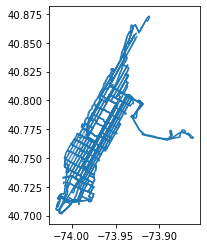

In [7]:
route_gdf.plot()

In [8]:
# Extract out routes represented as MultiLineString geometries.
ls_gdf = route_gdf[route_gdf['geometry'].geom_type == 'LineString']
mls_gdf = route_gdf[route_gdf['geometry'].geom_type == 'MultiLineString']

ls_gdf = ls_gdf.reset_index(drop=True)
mls_gdf = mls_gdf.reset_index(drop=True)

peek(ls_gdf)
peek(mls_gdf)

55


,route_id,route_dir,route_shor,route_long,color,geometry
0,M104,M104_0,M104,West Harlem - Times Square,#B933AD,"LINESTRING (-73.99014 40.75652, -73.99027 40.7..."
1,M104,M104_1,M104,West Harlem - Times Square,#B933AD,"LINESTRING (-73.95309 40.81422, -73.95311 40.8..."
2,M106,M106_0,M106,East Harlem - West Side,#6CBE45,"LINESTRING (-73.97265 40.79499, -73.97264 40.7..."


27


,route_id,route_dir,route_shor,route_long,color,geometry
0,M101,M101_0,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."
1,M101,M101_1,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.95142 40.78518, -73.9518..."
2,M102,M102_0,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."


In [9]:
def insert_end_of_line_string(line_string, coords):
    """Inserts the given LineString into the list of given coordinates by
    finding the coordinate in the list which matches the LineString ending
    coordinate and replacing all coordinates in the list before this matching
    coordinate with the coordinates of the LineString. Returns the result."""
    end_coord = line_string.coords[-1]
    insertion_index = coords.index(end_coord)
    return list(line_string.coords) + coords[insertion_index + 1:]

def insert_start_of_line_string(line_string, coords):
    """Inserts the given LineString into the list of given coordinates by
    finding the coordinate in the list which matches the LineString starting
    coordinate and replacing all coordinates in the list after this matching
    coordinate with the coordinates of the LineString. Returns the result."""
    start_coord = line_string.coords[0]
    insertion_index = coords.index(start_coord)
    return coords[:insertion_index] + list(line_string.coords)

# 2. MultiLineString Repair Algorithm

This algorithm takes all of the LineStrings within the given LineString and automatically produces the correctly-ordered sequence of coordinates which represent the actual bus route. This is accomplished in two parts:

(1) **Grow out the route from its center by connecting consecutive LineStrings.** LineStrings are placed in dictionaries keyed by their starting and ending coordinates. A center coordinate of the MultiLineString is selected as the starting grow coordinate, from which LineStrings are consecutively attached. A center coordinate is used because it is less likely to be located on an incorrect branch than the first or last coordinate of the MultiLineString.

(2) **Try attaching remaining unused LineString branches.** If not all LineStrings were attached using the consecutive-linking method, then the algorithm will attempt to check all of the remaining LineStrings to see if they represent the correct route. This is accomplished by connecting the LineString to the route built so far, seeing if it extends the length of the route, and using it if it does.

The ordered list of coordinates and LineString segments between them are then returned.

This algorithm may not be robust enough for unique situations, but appears to have correctly ordered and pruned all given Manhattan bus routes.

In [10]:
def repair_multi_line_string(multi_line_string):
    # Dictionaries of start/end coordinates to their encompassing LineString.
    line_string_start_dict = {}
    line_string_end_dict = {}
    # Ordered coordinates for the fixed geometry.
    new_coords = []

    for line_string in multi_line_string:
        start_coord = line_string.coords[0]
        end_coord = line_string.coords[-1]

        line_string_start_dict[start_coord] = line_string
        line_string_end_dict[end_coord] = line_string

    ### This first section grows out the route from its center by connecting
    ### consecutive LineStrings. This fixes the ordering issue by ordering
    ### coordinates based on the contiguity of their LineStrings.

    # Pick coordinate in middle of route to connect other coordinates to.
    grow_coord = multi_line_string[int(len(multi_line_string) / 2)].coords[0]
    new_coords.append(grow_coord)

    # Grow the fixed route by iteratively attaching LineStrings which start from
    # the current coordinate and setting the current coordinate to the end
    # coordinate of the LineString most recently attached.
    while grow_coord in line_string_start_dict:
        # Attach beginning of LineString to end of route so far
        matching_line_string = line_string_start_dict[grow_coord]
        new_coords = new_coords + matching_line_string.coords[1:]

        # Remove LineString from future consideration in route growing.
        del line_string_start_dict[grow_coord]
        end_coord = matching_line_string.coords[-1]
        if end_coord in line_string_end_dict:
            del line_string_end_dict[end_coord]

        # Set grow coordinate to end coordinate of LineString attached.
        grow_coord = end_coord

    # Grow the fixed route in the other direction.
    grow_coord = new_coords[0]
    while grow_coord in line_string_end_dict:
        # Attach end of matching LineString to beginning of route so far.
        matching_line_string = line_string_end_dict[grow_coord]
        new_coords = matching_line_string.coords[:-1] + new_coords

        # Remove LineString from future consideration in route growing.
        del line_string_end_dict[grow_coord]
        start_coord = matching_line_string.coords[0]
        if start_coord in line_string_start_dict:
            del line_string_start_dict[start_coord]

        grow_coord = start_coord

    ### This second section tries attaching different unused LineStrings to the
    ### route so far to see if they extend the route farther. This fixes the
    ### branching issue by forming the longest single contiguous coordinate
    ### sequence.

    # Iterate through all unused branches and try inserting branches to create a
    # longer route as long as at least one unused branch has been inserted.
    # Insert by matching the end of the branch.
    try_insertion = True
    while len(line_string_start_dict) > 0 and try_insertion:
        try_insertion = False
        remove_keys = []

        items = line_string_start_dict.items()
        for branch_start_coord, branch_line_string in items:
            branch_end_coord = branch_line_string.coords[-1]

            if branch_end_coord in new_coords:
                # Try using this LineString as the beginning branch of the
                # route so far. Use it if it makes a longer route.
                proposed_coords = insert_end_of_line_string(
                    branch_line_string, new_coords)
                if len(proposed_coords) > len(new_coords):
                    new_coords = proposed_coords

                    # Mark the removal of this branch from further
                    # consideration. Continue trying branches now that the route
                    # has changed.
                    remove_keys.append(branch_start_coord)
                    try_insertion = True

        # Remove added branches from consideration.
        for remove_key in remove_keys:
            del line_string_start_dict[remove_key]

    # Perform the identical branch insertion operation, but insert by matching
    # the start of the branch.
    try_insertion = True
    while len(line_string_end_dict) > 0 and try_insertion:
        try_insertion = False
        remove_keys = []
        
        items = line_string_end_dict.items()
        for branch_end_coord, branch_line_string in items:
            start_coord = branch_line_string.coords[0]
            
            if start_coord in new_coords:
                appended_coords = insert_start_of_line_string(
                    branch_line_string, new_coords)
                if len(appended_coords) > len(new_coords):
                    new_coords = appended_coords
                    remove_keys.append(branch_end_coord)
                    try_insertion = True
                    
        for remove_key in remove_keys:
            del line_string_end_dict[remove_key]

    # Construct list of LineStrings connecting consecutive coordinates.
    new_line_strings = []
    for i in range(len(new_coords) - 1):
        new_line_string = LineString(tuple(new_coords[i:i + 2]))
        new_line_strings.append(new_line_string)

    return {
        'coords': new_coords,
        'segments': new_line_strings
    }

In [11]:
def order_line_strings_as_gdf(line_strings):
    """Returns the list of LineStrings as a GeoDataFrame with a LineString in each row."""
    return gpd.GeoDataFrame({}, geometry=line_strings, crs=CRS_LATLON)

In [12]:
def plot_ordered_gdfs(before_gdf, after_gdf, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    
    # Color by index to visualize order of LineStrings in GeoDataFrames.
    before_gdf.reset_index().plot(ax=ax[0], column='index')
    after_gdf.reset_index().plot(ax=ax[1], column='index')
    
    ax[0].set_facecolor('#444')
    ax[1].set_facecolor('#444')
    ax[0].set_title(f"Before: {title} ({len(before_gdf)})")
    ax[1].set_title(f"After: {title} ({len(after_gdf)})")
    plt.show()

## 2.1 Repair and Visualize Results

Every MultiLineString is sent through the repair algorithm and visualized to check for correctness. The plots use a color scale to visualize the order of coordinates in the MultiLineString sequence (before) and the repaired LineString segments (after). A correctly repaired route appears to have a similar geometry to the original MultiLineString (i.e. it's not missing large portions), does not contain non-consecutive branches, and has a clearly smooth color transition along the color scale (i.e. yellow and purple colors are not interleaved).

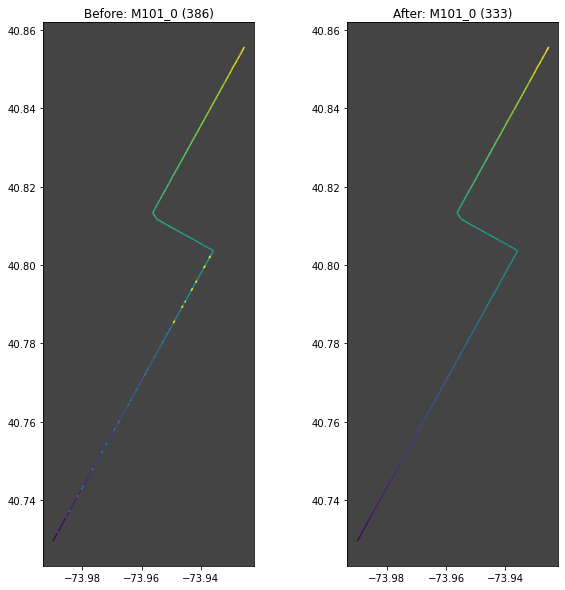

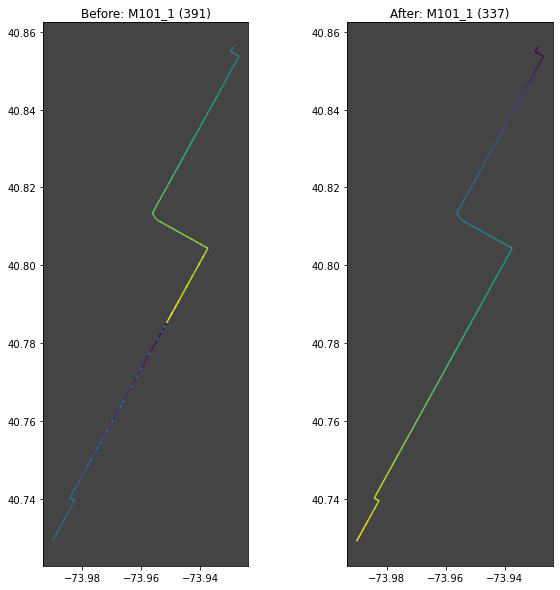

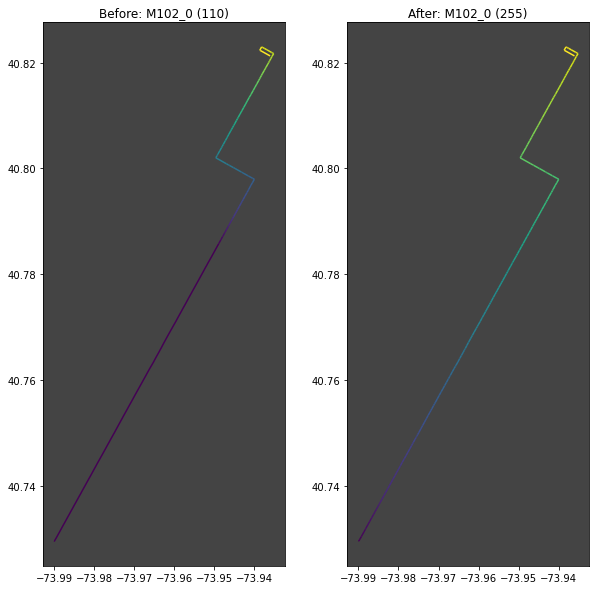

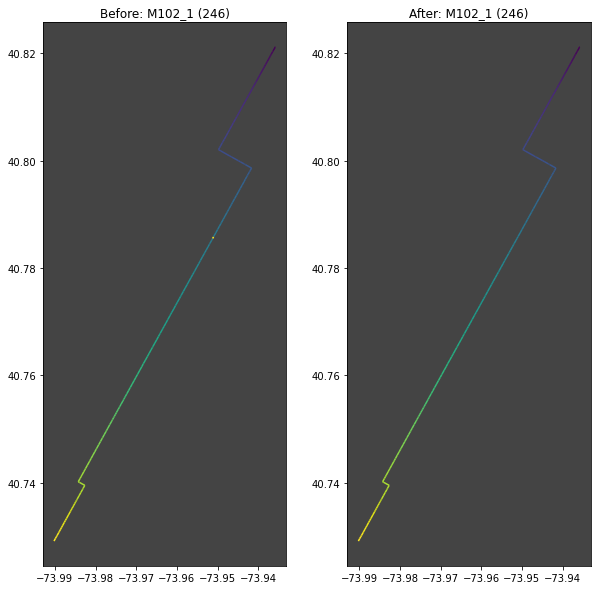

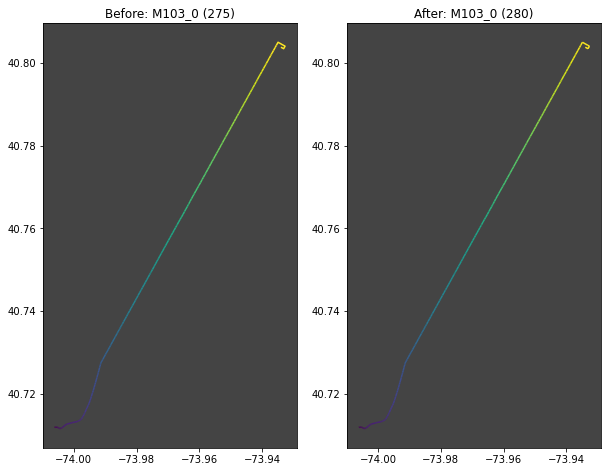

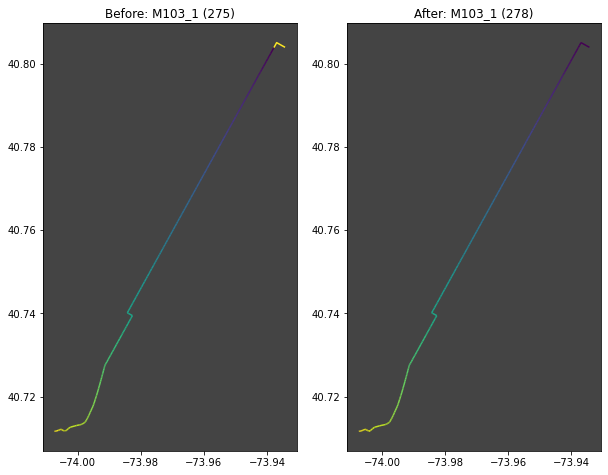

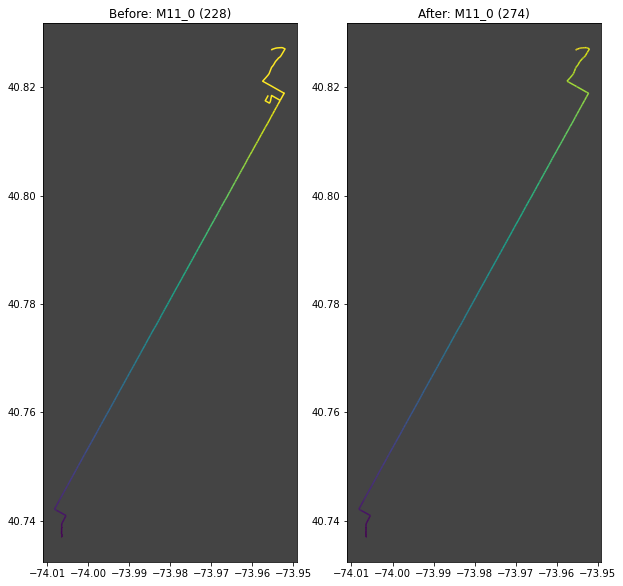

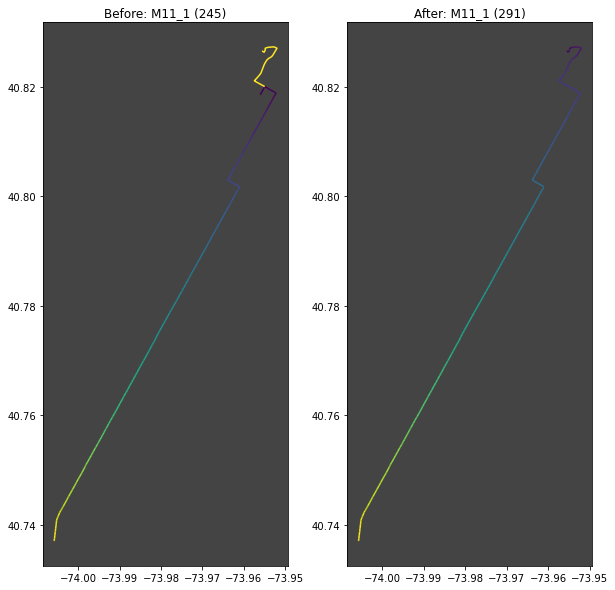

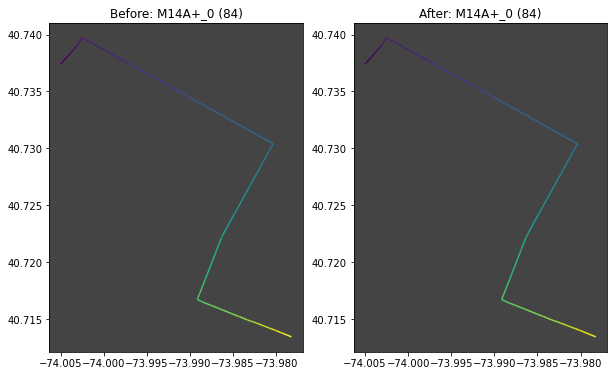

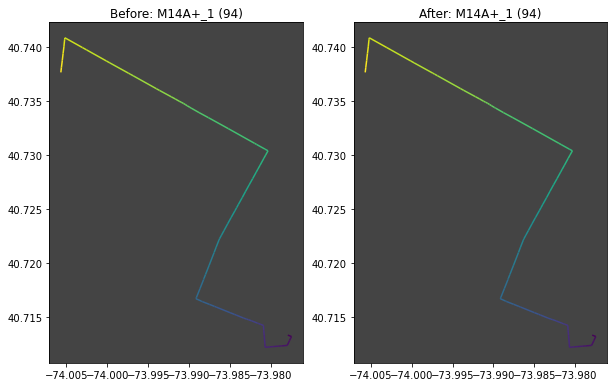

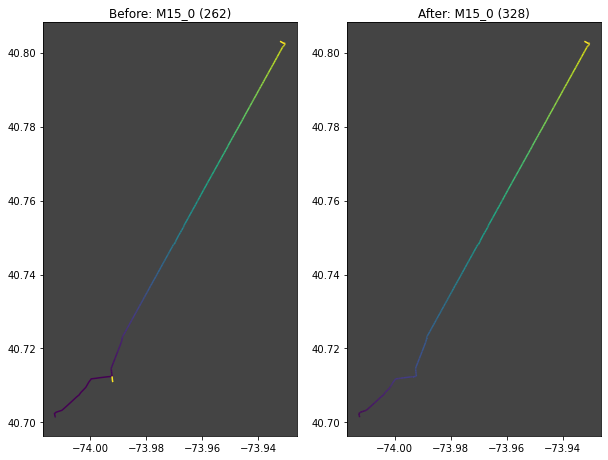

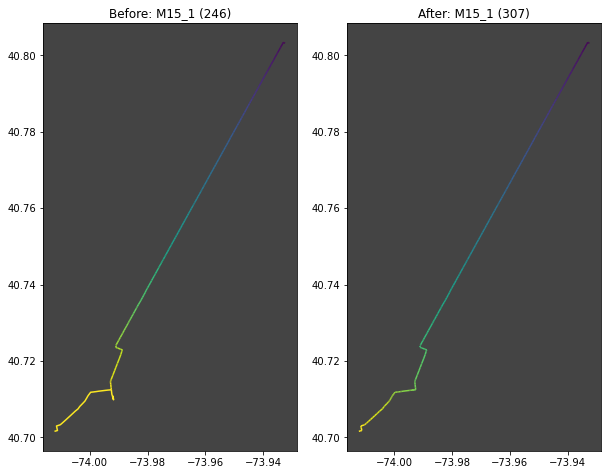

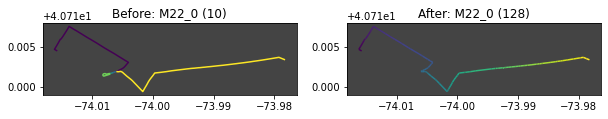

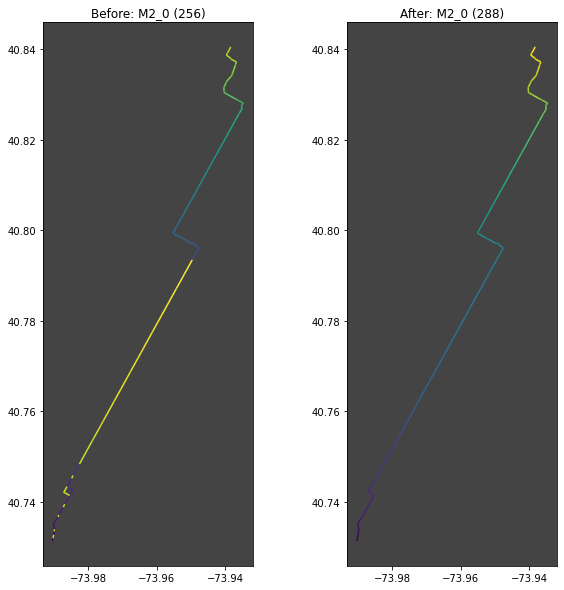

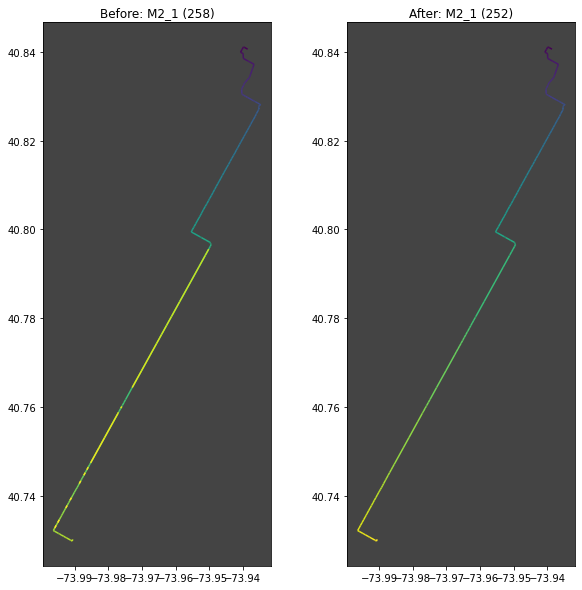

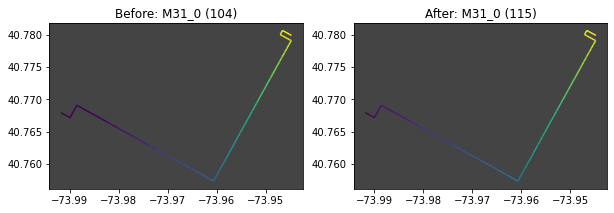

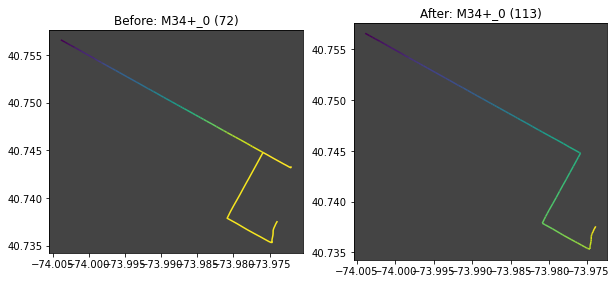

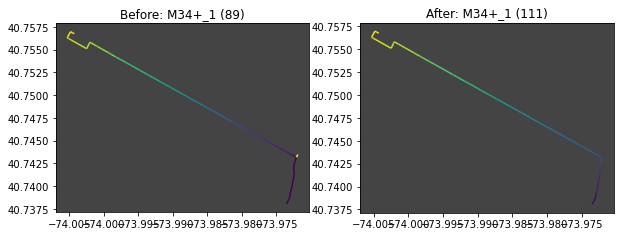

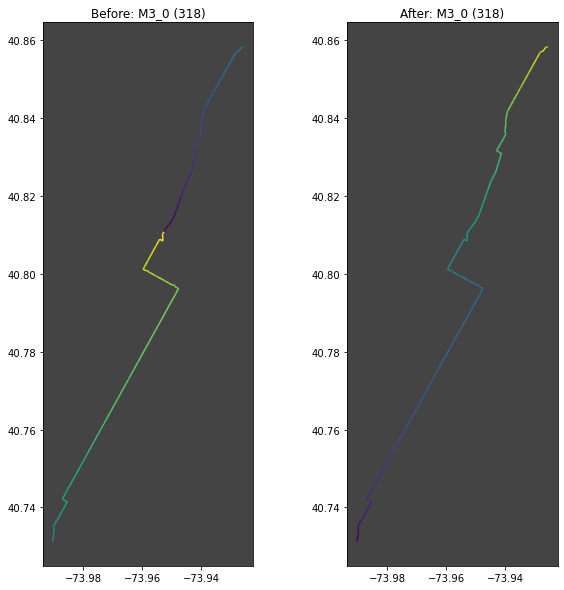

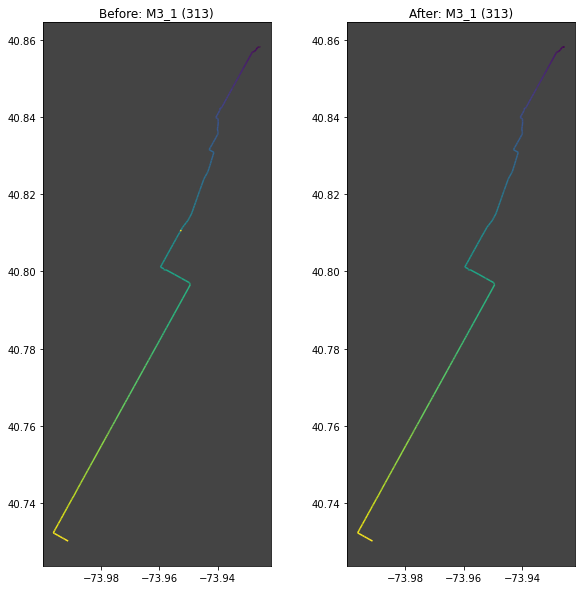

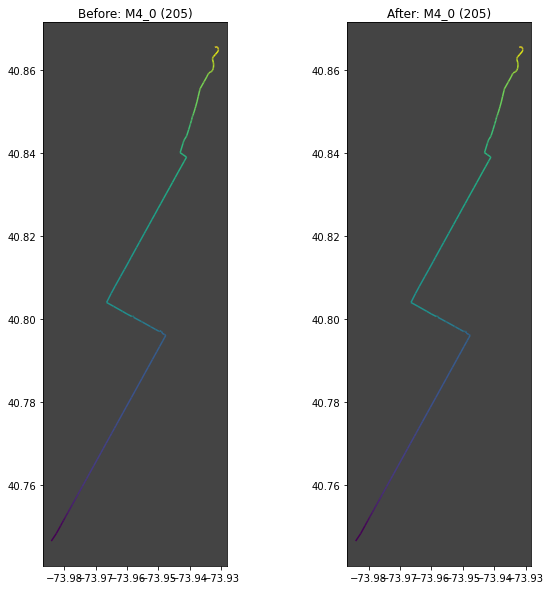

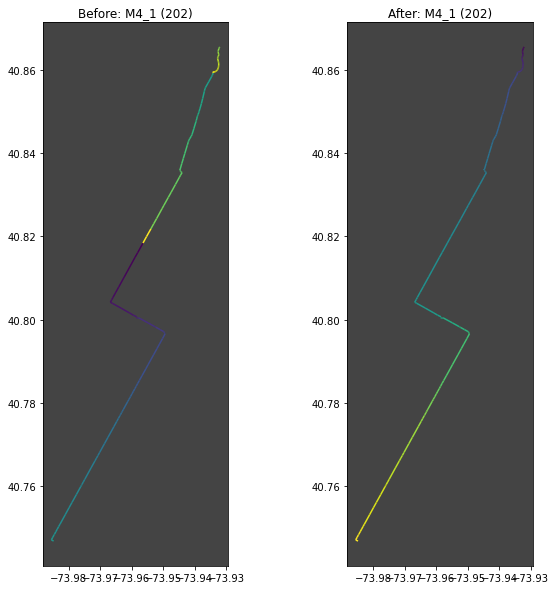

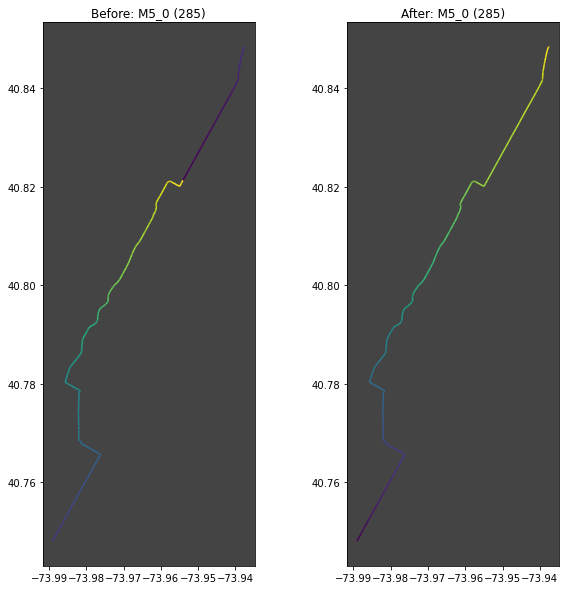

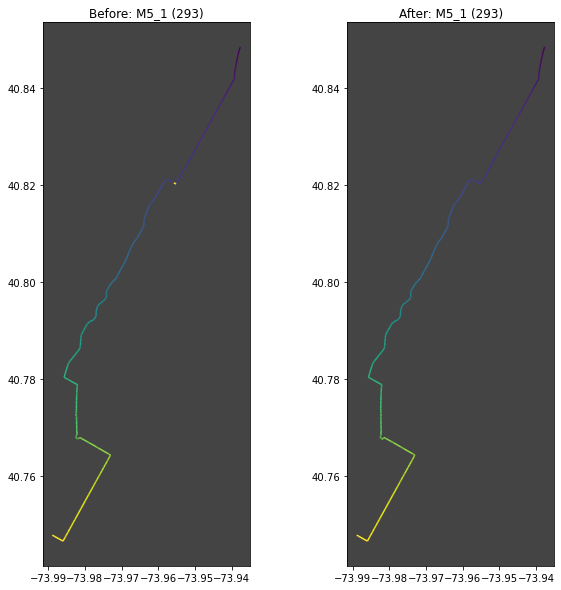

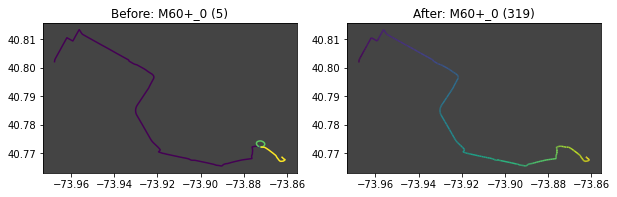

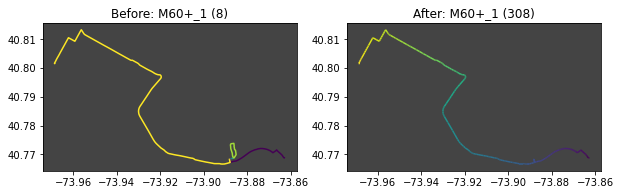

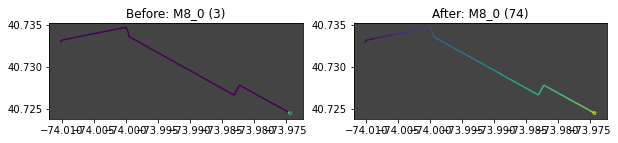

In [13]:
# Repair all MultiLineString geometries and visualize before/after results.

repaired_ls_gdf = mls_gdf.copy()
for i in range(len(mls_gdf)):
    route_dir = mls_gdf.iloc[i]['route_dir']
    multi_line_string = mls_gdf.iloc[i]['geometry']
    before_gdf = order_line_strings_as_gdf(list(multi_line_string))
    
    result = repair_multi_line_string(multi_line_string)
    after_coords = result['coords']
    after_segments = result['segments']
    after_gdf = order_line_strings_as_gdf(after_segments)

    plot_ordered_gdfs(before_gdf, after_gdf, route_dir)
    
    repaired_ls_gdf.loc[i, 'geometry'] = LineString(after_coords)

# 3. Visualize and Export Repaired Shapefile

Here the repaired LineString routes are combined back with the other LineString routes which did not require repair. These are visualized one last time to show combined results.

In [14]:
peek(mls_gdf)
peek(repaired_ls_gdf)

27


,route_id,route_dir,route_shor,route_long,color,geometry
0,M101,M101_0,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."
1,M101,M101_1,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.95142 40.78518, -73.9518..."
2,M102,M102_0,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."


27


,route_id,route_dir,route_shor,route_long,color,geometry
0,M101,M101_0,M101,East Village - Harlem,#FAA61A,"LINESTRING (-73.99003 40.72960, -73.98991 40.7..."
1,M101,M101_1,M101,East Village - Harlem,#FAA61A,"LINESTRING (-73.92875 40.85611, -73.92917 40.8..."
2,M102,M102_0,M102,Harlem - East Village,#FAA61A,"LINESTRING (-73.99003 40.72960, -73.98991 40.7..."


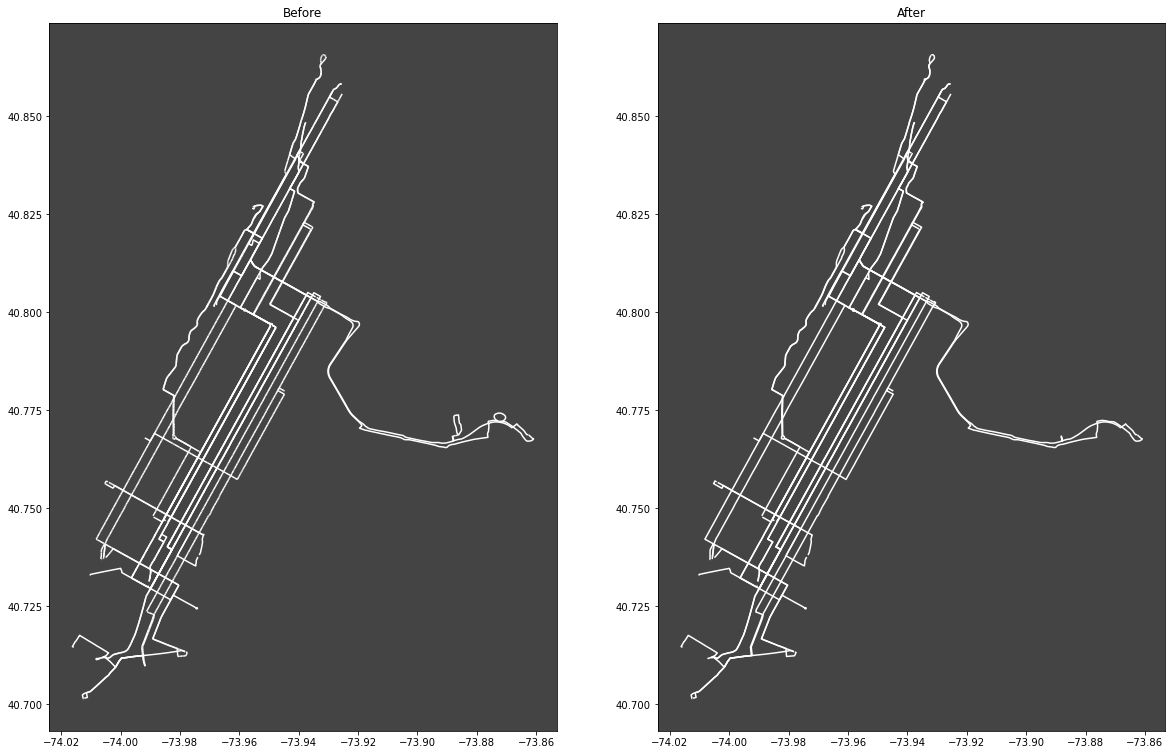

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
mls_gdf.plot(ax=ax[0], color='#fff')
repaired_ls_gdf.plot(ax=ax[1], color='#fff')
ax[0].set_facecolor('#444')
ax[1].set_facecolor('#444')
ax[0].set_title('Before')
ax[1].set_title('After')
plt.show()

In [16]:
all_ls_gdf = pd.concat([ls_gdf, repaired_ls_gdf])
all_ls_gdf = all_ls_gdf.sort_values(by=['route_dir'])
all_ls_gdf = all_ls_gdf.reset_index(drop=True)
all_ls_gdf

,route_id,route_dir,route_shor,route_long,color,geometry
0,M100,M100_0,M100,Inwood - Manhattanville,#00AEEF,"LINESTRING (-73.93269 40.80405, -73.93264 40.8..."
1,M100,M100_1,M100,Inwood - Manhattanville,#00AEEF,"LINESTRING (-73.91260 40.87245, -73.91200 40.8..."
2,M101,M101_0,M101,East Village - Harlem,#FAA61A,"LINESTRING (-73.99003 40.72960, -73.98991 40.7..."
3,M101,M101_1,M101,East Village - Harlem,#FAA61A,"LINESTRING (-73.92875 40.85611, -73.92917 40.8..."
4,M102,M102_0,M102,Harlem - East Village,#FAA61A,"LINESTRING (-73.99003 40.72960, -73.98991 40.7..."
...,...,...,...,...,...,...
77,M8,M8_1,M8,West Village - East Village LTD,#00AEEF,"LINESTRING (-73.97550 40.72502, -73.97621 40.7..."
78,M96,M96_0,M96,East Side - West Side,#6CBE45,"LINESTRING (-73.97265 40.79499, -73.97264 40.7..."
79,M96,M96_1,M96,East Side - West Side,#6CBE45,"LINESTRING (-73.94552 40.78448, -73.94614 40.7..."
80,M9,M9_0,M9,Battery Park City - Kips Bay,#B933AD,"LINESTRING (-74.01583 40.71149, -74.01580 40.7..."


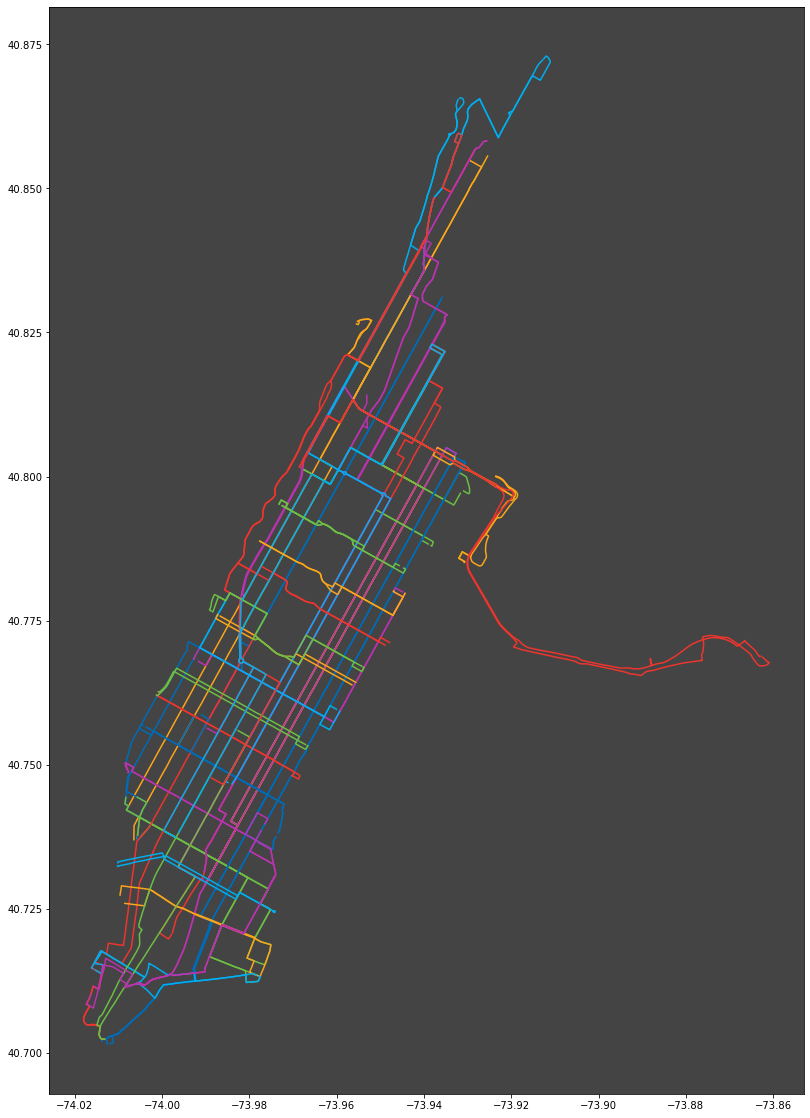

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
all_ls_gdf.plot(ax=ax, color=all_ls_gdf['color'])
ax.set_facecolor('#444')
plt.show()

In [18]:
all_ls_gdf.to_file(f'{EXPORTS_DIR}/shp/manhattan/bus_routes_nyc_may2020.shp')